In [2]:
import os
from glob import glob
import random

import torch
from torchvision import datasets as dset
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from model import SiameseNet
from config_maker import get_config

Download MNIST data

In [3]:
transformer = transforms.Compose([
                    transforms.Resize(105),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=0.5,std=0.5)])

# If you run this code first time, make 'download' option True
test_data = dset.MNIST(root='MNIST_data/',train=False,transform=transformer, download=False)

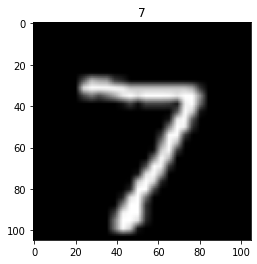

torch.Size([1, 105, 105])
number of test data: 10000


In [4]:
test_image, test_label = test_data[0]

plt.imshow(test_image.squeeze().numpy(), cmap='gray')
plt.title('%i' % test_label)
plt.show()

print(test_image.size())
print('number of test data:', len(test_data))

Make Dataloader

In [5]:
class MNISTTest(Dataset):
    def __init__(self, dataset,trial):
        self.dataset = dataset
        self.trial = trial
        if trial > 950:
            self.trial = 950

    def __len__(self):
        return self.trial * 10

    def __getitem__(self, index):
        share, remain = divmod(index,10)
        label = (share//10)%10
        image1 = self.dataset[label][share][0]
        image2 = self.dataset[remain][random.randrange(len(self.dataset[remain]))][0]

        return image1, image2, label

In [6]:
image_by_num = [[],[],[],[],[],[],[],[],[],[]]
for x,y in tqdm(test_data):
    image_by_num[y].append(x)

test_data1 = MNISTTest(image_by_num,trial=950) #MAX trial = 950
test_loader = DataLoader(test_data1, batch_size=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

Declare model and configuration

In [7]:
config = get_config()
model = SiameseNet()
is_best = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

[*] use GPU Quadro RTX 4000


Load trained model

In [10]:
if is_best:
    model_path = os.path.join(config.logs_dir, './models/best_model.pt')
else:
    model_path = sorted(glob(config.logs_dir + './models/model_ckpt_*.pt'), key=len)[-1]

ckpt = torch.load(model_path)

model.load_state_dict(ckpt['model_state'])
model.to(device)
print(f"[*] Load model number {config.num_model}, best accuracy {ckpt['best_valid_acc']}")

[*] Load model number 1, best accuracy 0.903125


Test

In [ ]:
correct_sum = 0
num_test = len(test_loader)
print(f"[*] Test on {num_test} pairs.")

pbar = tqdm(enumerate(test_loader), total=num_test, desc="Test")
for i, (x1, x2, y) in pbar:
    # plt.figure(figsize=(20,7))
    # plt.subplot(1,4,1)
    # plt.title("Target")
    # plt.imshow(x1[0].squeeze().numpy(), cmap='gray')
    #
    # s = 2
    # for idx in range(10):
    #     plt.subplot(3,4,s)
    #     plt.title(idx)
    #     plt.imshow(x2[idx].squeeze().numpy(), cmap='gray')
    #     s += 1
    #     if s % 4 == 1:
    #         s += 1
    # plt.show()
    # break

    if torch.cuda.is_available():
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    x1, x2 = x1.unsqueeze(1), x2.unsqueeze(1)

    # compute log probabilities
    out = model(x1, x2)
    y_pred = torch.sigmoid(out)
    y_pred = torch.argmax(y_pred)
    if y_pred == y[0].item():
        correct_sum += 1

    pbar.set_postfix_str(f"accuracy: {correct_sum} / {num_test}")

test_acc = (100. * correct_sum) / num_test
print(f"Test Acc: {correct_sum}/{num_test} ({test_acc:.2f}%)")